# Compare GPs + Plot

In [1]:
import fastgp
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot

In [2]:
torch.set_default_dtype(torch.float64)
device = "cpu"

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [4]:
d = 1 
f = lambda x: 15*(x[:,0]-1/2)**2*torch.sin(2*torch.pi*x[:,0])
fp = lambda x: 30*(x[:,0]-1/2)*torch.sin(2*torch.pi*x[:,0])+15*2*torch.pi*(x[:,0]-1/2)**2*torch.cos(2*torch.pi*x[:,0])
xticks = torch.linspace(0,1,252)[1:-1,None]
yticks = f(xticks)
ypticks = fp(xticks)
print("xticks.shape = %s"%str(tuple(xticks.shape)))
print("yticks.shape = %s"%str(tuple(yticks.shape)))
print("ypticks.shape = %s"%str(tuple(ypticks.shape)))

xticks.shape = (250, 1)
yticks.shape = (250,)
ypticks.shape = (250,)


## Fast GP Construction

In [5]:
gps = [
    fastgp.StandardGP(seqs=qp.DigitalNetB2(1,seed=11,randomize="DS")),
    fastgp.FastGPDigitalNetB2(seqs=qp.DigitalNetB2(1,seed=7,randomize="DS"),alpha=4),
    fastgp.FastGPLattice(seqs=qp.Lattice(1,seed=7),alpha=2),
]

In [6]:
gps_grad = [
    fastgp.StandardGP(
        seqs = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=11,randomize="DS")],
        num_tasks = 2,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
    ),
    fastgp.FastGPDigitalNetB2(
        seqs = [qp.DigitalNetB2(1,seed=7,randomize="DS"),qp.DigitalNetB2(1,seed=11,randomize="DS")],
        num_tasks = 2,
        alpha = 4,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
    ),
    fastgp.FastGPLattice(
        seqs = [qp.Lattice(1,seed=7),qp.Lattice(1,seed=11)],
        num_tasks = 2,
        alpha = 2,
        derivatives = [torch.tensor([0]),torch.tensor([1])],
    ),
]

## GP Fitting

In [7]:
pmeans = [None]*len(gps)
pci_lows = [None]*len(gps)
pci_highs = [None]*len(gps)
for i,gp in enumerate(gps):
    print(type(gp).__name__)
    x_next = gp.get_x_next(n=2**6)
    gp.add_y_next(f(x_next))
    gp.fit()
    pmeans[i],_,_,pci_lows[i],pci_highs[i] = gp.post_ci(xticks,confidence=0.95)
    print("\tl2 relative error = %.1e"%(torch.linalg.norm(yticks-pmeans[i])/torch.linalg.norm(yticks)))


StandardGP
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.98e+04   | 6.02e+04   | -5.54e+02 
            5.00e+00 | 5.95e+04   | 5.99e+04   | -5.53e+02 
            1.00e+01 | 5.84e+04   | 5.89e+04   | -5.51e+02 
            1.50e+01 | 4.27e+04   | 4.31e+04   | -5.45e+02 
            2.00e+01 | -1.35e+02  | 2.68e+02   | -5.21e+02 
            2.50e+01 | -3.62e+02  | 1.97e+01   | -5.00e+02 
            3.00e+01 | -3.66e+02  | 1.21e+01   | -4.95e+02 
            3.50e+01 | -3.66e+02  | 8.94e+00   | -4.93e+02 
            4.00e+01 | -3.66e+02  | 8.87e+00   | -4.93e+02 
            4.50e+01 | -3.67e+02  | 1.01e+01   | -4.94e+02 
            5.00e+01 | -3.67e+02  | 9.14e+00   | -4.93e+02 
            5.50e+01 | -3.67e+02  | 9.52e+00   | -4.94e+02 
            5.80e+01 | -3.67e+02  | 9.11e+00   | -4.93e+02 
	l2 relative error = 8.7e-04
FastGPDigitalNetB2
     iter of 5.0e+03 | NMLL       | nor

In [8]:
pmeans_grad = [None]*len(gps_grad)
pci_lows_grad = [None]*len(gps_grad)
pci_highs_grad = [None]*len(gps_grad)
for i,gp in enumerate(gps_grad):
    print(type(gp).__name__)
    x_next = gp.get_x_next(n=[2**6,2**3])
    gp.add_y_next([f(x_next[0]),fp(x_next[1])])
    gp.fit()
    pmeans_grad[i],_,_,pci_lows_grad[i],pci_highs_grad[i] = gp.post_ci(xticks,confidence=0.95)
    print("\tl2 relative error = %.1e"%(torch.linalg.norm(yticks-pmeans_grad[i][0])/torch.linalg.norm(yticks)))

StandardGP
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.29e+06   | 1.29e+06   | -6.19e+02 
            5.00e+00 | 1.18e+06   | 1.18e+06   | -6.18e+02 
            1.00e+01 | 8.17e+05   | 8.18e+05   | -6.15e+02 
            1.50e+01 | 1.75e+05   | 1.75e+05   | -6.06e+02 
            2.00e+01 | -1.49e+02  | 2.93e+02   | -5.75e+02 
            2.50e+01 | -3.96e+02  | 1.99e+01   | -5.48e+02 
            3.00e+01 | -3.98e+02  | 1.54e+01   | -5.46e+02 
            3.50e+01 | -3.99e+02  | 1.02e+01   | -5.42e+02 
            4.00e+01 | -3.99e+02  | 8.51e+00   | -5.40e+02 
            4.50e+01 | -3.99e+02  | 9.52e+00   | -5.41e+02 
            4.70e+01 | -3.99e+02  | 1.01e+01   | -5.42e+02 
	l2 relative error = 5.4e-04
FastGPDigitalNetB2
     iter of 5.0e+03 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 9.99e+02   | 1

## Plot

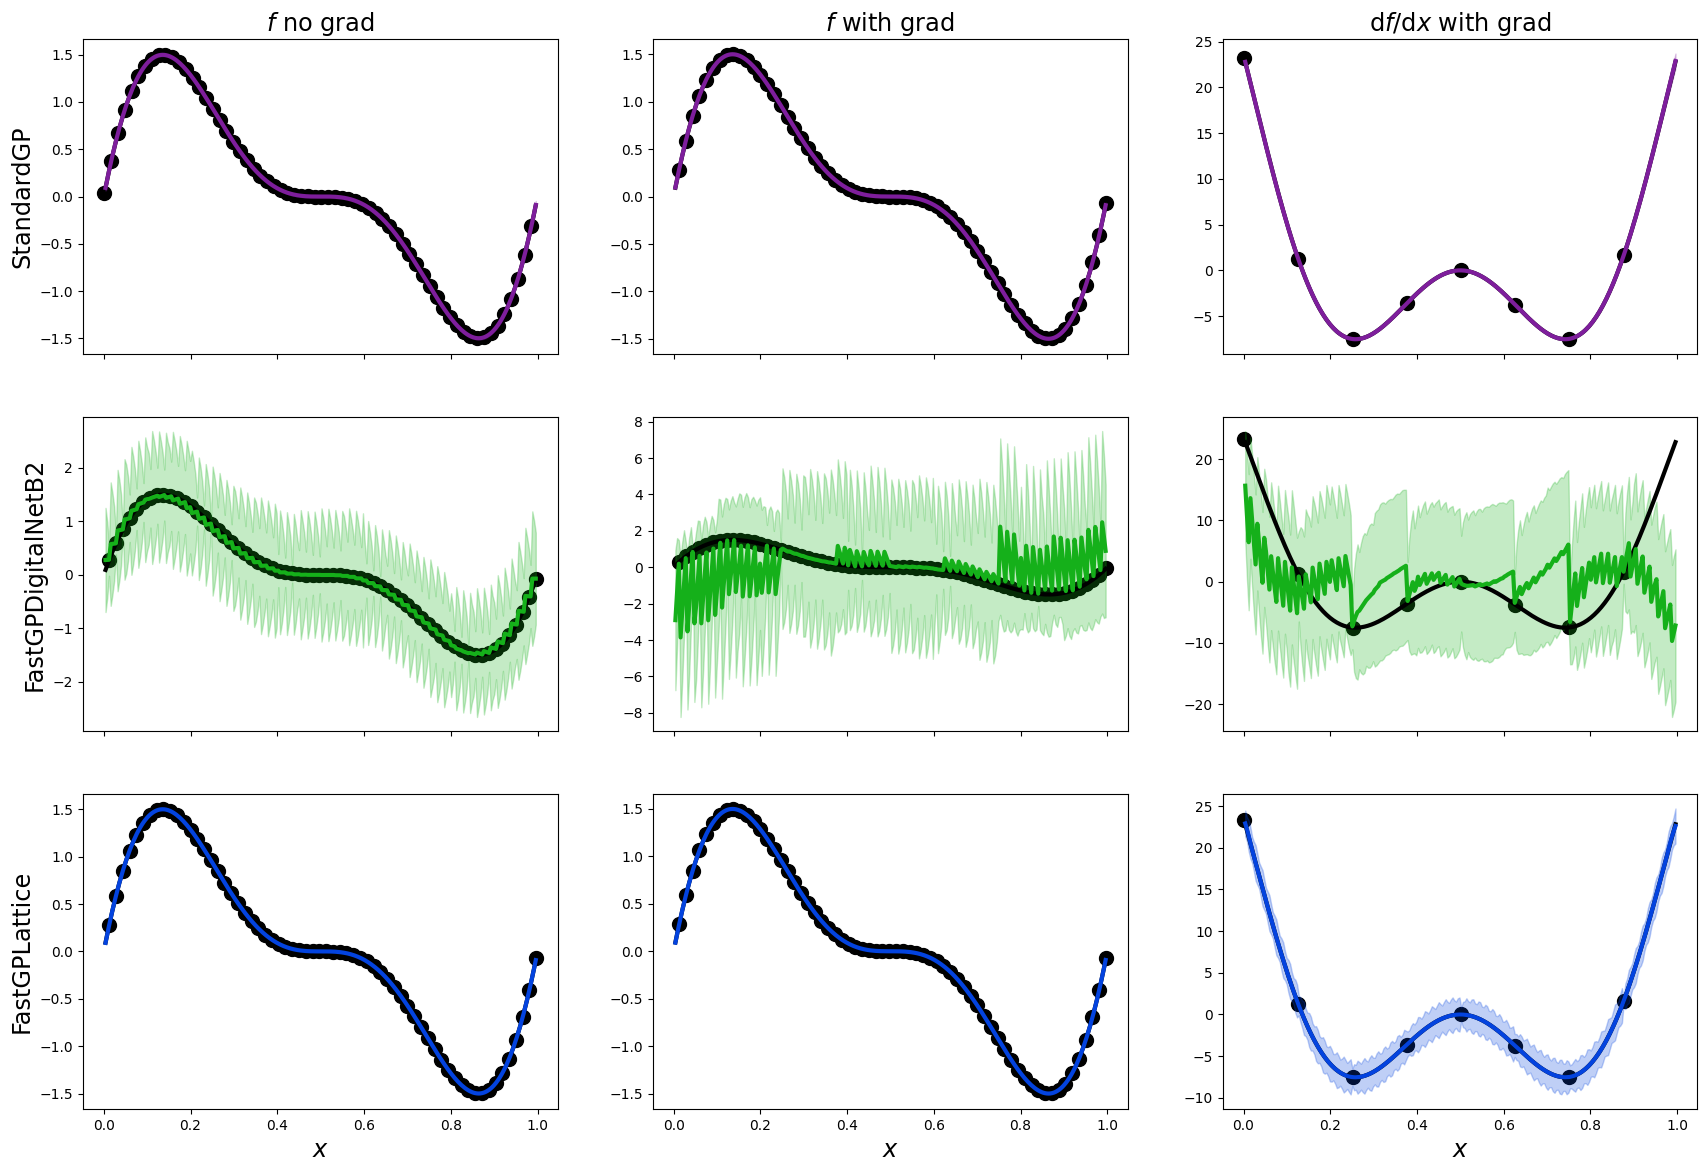

In [9]:
fig,ax = pyplot.subplots(nrows=len(gps),ncols=3,sharex=True,sharey=False,figsize=(WIDTH*1.5,WIDTH/len(gps)*3))
ax = ax.reshape((len(gps),3))
for i,gp in enumerate(gps):
    ax[i,0].set_ylabel(type(gp).__name__,fontsize="xx-large")
    ax[i,0].plot(xticks[:,0],yticks,color="k",linewidth=LINEWIDTH)
    ax[i,0].scatter(gp.x[:,0],gp.y,color="k",s=MARKERSIZE)
    ax[i,0].plot(xticks[:,0],pmeans[i],color=colors[i],linewidth=LINEWIDTH)
    ax[i,0].fill_between(xticks[:,0],pci_lows[i],pci_highs[i],color=colors[i],alpha=_alpha)
for i,gp in enumerate(gps_grad):
    ax[i,1].plot(xticks[:,0],yticks,color="k",linewidth=LINEWIDTH)
    ax[i,2].plot(xticks[:,0],ypticks,color="k",linewidth=LINEWIDTH)
    ax[i,1].scatter(gp.x[0][:,0],gp.y[0],color="k",s=MARKERSIZE)
    ax[i,2].scatter(gp.x[1][:,0],gp.y[1],color="k",s=MARKERSIZE)
    ax[i,1].plot(xticks[:,0],pmeans_grad[i][0],color=colors[i],linewidth=LINEWIDTH)
    ax[i,2].plot(xticks[:,0],pmeans_grad[i][1],color=colors[i],linewidth=LINEWIDTH)
    ax[i,1].fill_between(xticks[:,0],pci_lows_grad[i][0],pci_highs_grad[i][0],color=colors[i],alpha=_alpha)
    ax[i,2].fill_between(xticks[:,0],pci_lows_grad[i][1],pci_highs_grad[i][1],color=colors[i],alpha=_alpha)
ax[0,0].set_title(r"$f$ no grad",fontsize="xx-large")
ax[0,1].set_title(r"$f$ with grad",fontsize="xx-large")
ax[0,2].set_title(r"$\mathrm{d} f / \mathrm{d} x$ with grad",fontsize="xx-large")
for j in range(3):
    ax[-1,j].set_xlabel(r"$x$",fontsize="xx-large")
fig.savefig("./gps_deriv.pdf",bbox_inches="tight")